In [1]:
import numpy as np
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Задание 1. Линейные системы. Устойчивость численных методов.

Решить численно задачу о колебаниях в системе, где и возвращающая сила, и
коэффициент вязкого трения убывают со временем (уравнение Эйлера):
$$
\ddot{x} + 100\,\dfrac{x}{t^2} = 0
$$ 
Сначала решим численно!
Подстановка $x = t^\alpha$ дает следующее уравнение:
$$
\boxed{
    x (t) = C_1 \sqrt{t} \sin \left( \frac{1}{2} \sqrt{399} \ln{t} \right) + C_2 \sqrt{t} \cos \left( \frac{1}{2} \sqrt{399} \ln{t} \right)
}
$$

In [2]:
# Запишем решение
C1, C2, t = symbols('C1 C2 t')

sol = C1*sqrt(t)*sin(0.5*sqrt(399)*log(t)) \
                        + C2*sqrt(t)*cos(0.5*sqrt(399)*log(t))

sol_d1 = lambdify(t, diff(sol, t))
C1_sol, C2_sol = list(solve([sol_d1(1) - 1, sol.subs(t, 1) - 1]).values())
t_theor = lambdify(t, sol.subs(C1, C1_sol).subs(C2, C2_sol))

In [3]:
system_of_eq = lambda t, x: np.array([
    1.0,  # Время
    x[2],  # x точка
    -100.0*x[1]/x[0]**2,  # p точка
])

# Стартовая точка
t0 = 1.0
x_start = np.array([t0, 1.0, 1.0])
# Диапазон конечного времени
T_list = [1, 10, 100, 1000]
T_list = [i+1 for i in T_list]
# Шаг
h = 0.1

## Методы Эйлера

Для решения методом Эйлера разобьем на нормальную систему уравнений:

$$
\begin{cases}
    \dot{x} = p \\
    \dot{p} = -100\, \cfrac{x}{t^2}
\end{cases}
$$

### Явный метод Эйлера

In [4]:
from utils.simple_solvers import eiler_1
from utils.plot_helpers import describe_after_execution

----------------------------------------------------------
                   T = 2


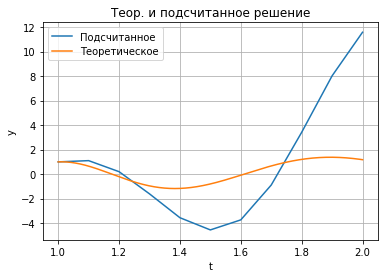

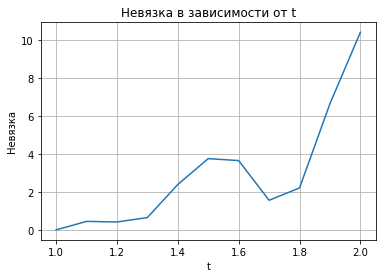

  Вычисленное x(101) = 11.576337299199986
  Теоретическое x(101) = 1.1769175165576888
----------------------------------------------------------
----------------------------------------------------------
                   T = 11


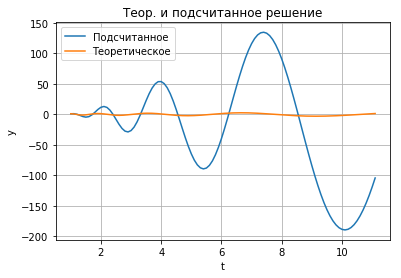

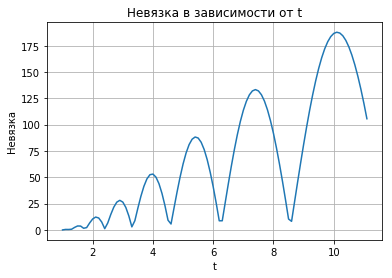

  Вычисленное x(101) = -104.20089769070776
  Теоретическое x(101) = 1.0980225418856266
----------------------------------------------------------
----------------------------------------------------------
                   T = 101


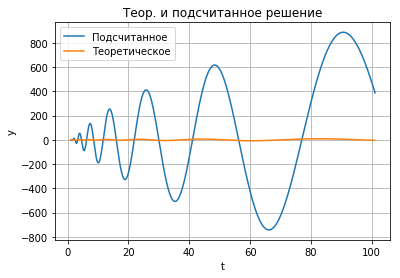

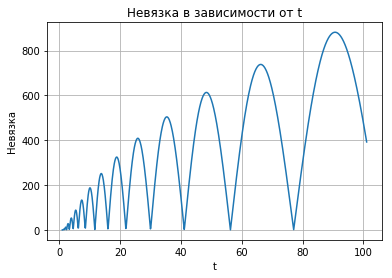

  Вычисленное x(101) = 387.60543228423273
  Теоретическое x(101) = -4.73890168470781
----------------------------------------------------------
----------------------------------------------------------
                   T = 1001


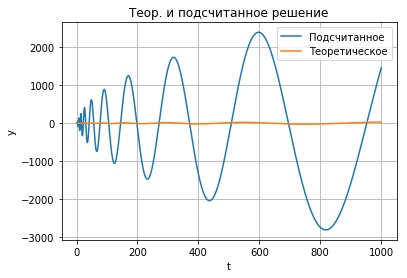

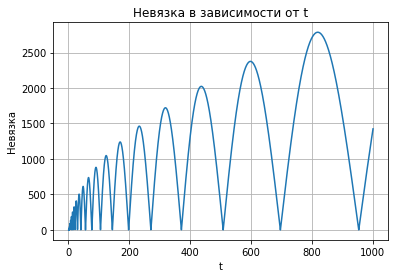

  Вычисленное x(101) = 1455.4886029208014
  Теоретическое x(101) = 31.25354025178528
----------------------------------------------------------


In [5]:
for t_stop in T_list:
    describe_after_execution(t_theor)(eiler_1)(lambda x: system_of_eq(t0, x), x_start.copy(), t_stop, h)

Результаты очень плохие. Это объясняется тем, что явный метод Эйлера дает ошибку $o (h)$, которая в нашем случае оказалась велика.

### Неявный метод Эйлера

----------------------------------------------------------
                   T = 2


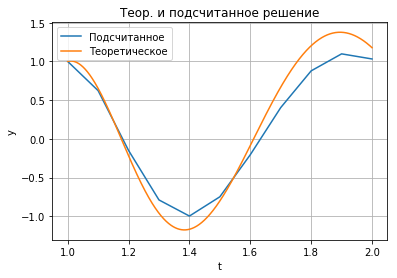

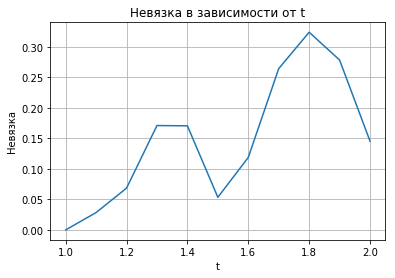

  Вычисленное x(101) = 1.031400416860595
  Теоретическое x(101) = 1.1769175165576888
----------------------------------------------------------
----------------------------------------------------------
                   T = 11


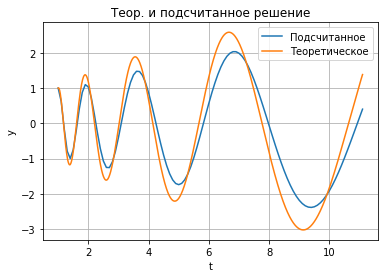

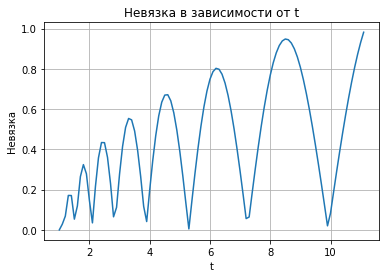

  Вычисленное x(101) = 0.40122658951560275
  Теоретическое x(101) = 1.0980225418856266
----------------------------------------------------------
----------------------------------------------------------
                   T = 101


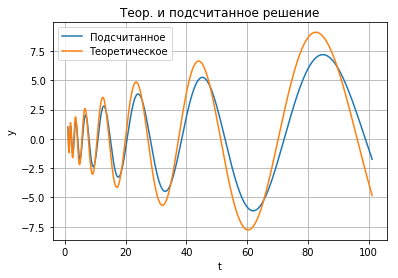

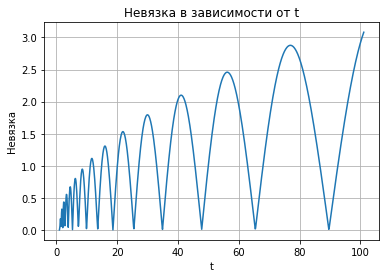

  Вычисленное x(101) = -1.7472631764270972
  Теоретическое x(101) = -4.73890168470781
----------------------------------------------------------
----------------------------------------------------------
                   T = 1001


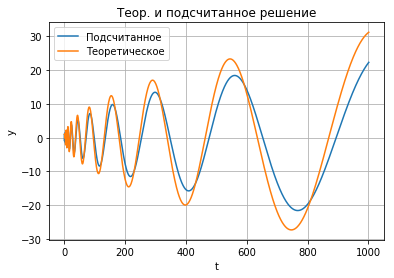

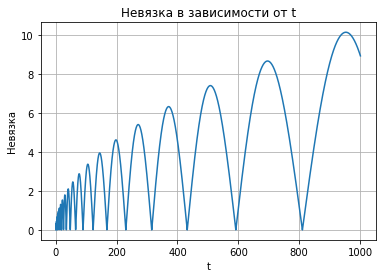

  Вычисленное x(101) = 22.334590075658493
  Теоретическое x(101) = 31.25354025178528
----------------------------------------------------------


In [6]:
from utils.simple_solvers import eiler_2
for t_stop in T_list:
    describe_after_execution(t_theor)(eiler_2)(lambda x: system_of_eq(t0, x), x_start.copy(), t_stop, h)

Неявный метод Эйлера дает неплохие результаты. Более того, он оказывается самым точным, поскольку дает точность $o(h^2)$, к тому же, имеет повышенную устройчивость и позволяет обойти некоторые проблемы при решении жестких систем ДУ.

### Метод Эйлера с центральной точкой

----------------------------------------------------------
                   T = 2


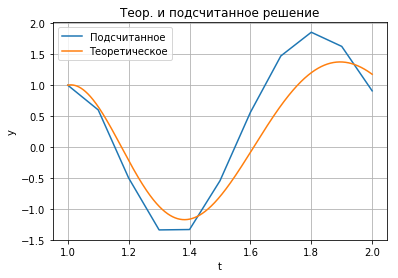

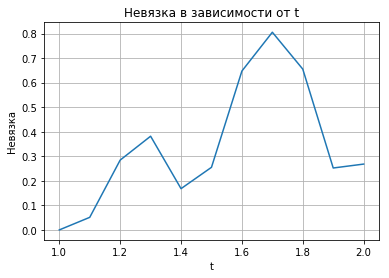

  Вычисленное x(101) = 0.9087053580203962
  Теоретическое x(101) = 1.1769175165576888
----------------------------------------------------------
----------------------------------------------------------
                   T = 11


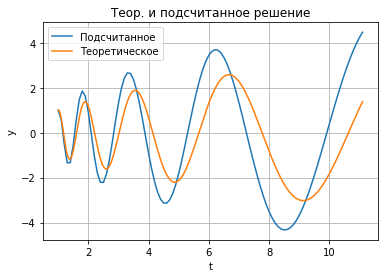

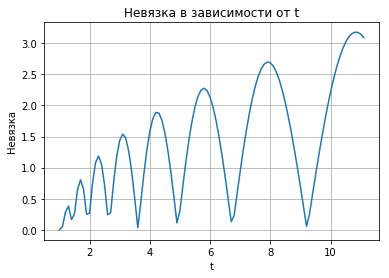

  Вычисленное x(101) = 4.470285170153841
  Теоретическое x(101) = 1.0980225418856266
----------------------------------------------------------
----------------------------------------------------------
                   T = 101


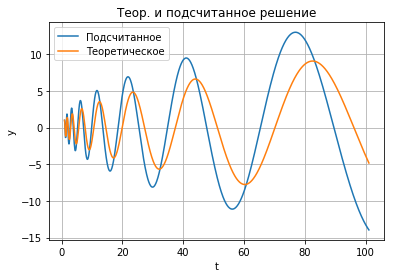

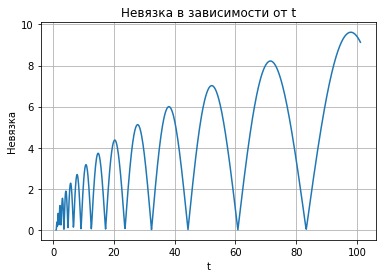

  Вычисленное x(101) = -13.961618490145836
  Теоретическое x(101) = -4.73890168470781
----------------------------------------------------------
----------------------------------------------------------
                   T = 1001


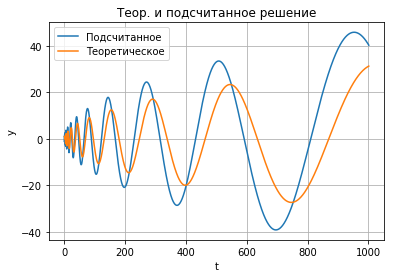

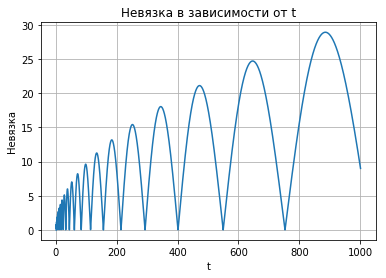

  Вычисленное x(101) = 40.25689247225262
  Теоретическое x(101) = 31.25354025178528
----------------------------------------------------------


In [7]:
from utils.simple_solvers import eiler_3

for t_stop in T_list:
    describe_after_execution(t_theor)(eiler_3)(lambda x: system_of_eq(t0, x), x_start.copy(), t_stop, h)

Метод Эйлера с центральной точкой дает результаты лучше явного, но хуже неявного (из-за меньшей устойчивости по сравнению с неявным).

## Метод Дормана-Принса

In [8]:
from utils.runge_kutta import dorman_prince

----------------------------------------------------------
                   T = 2


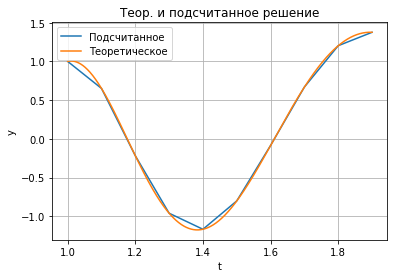

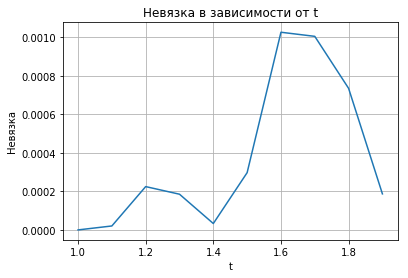

  Вычисленное x(101) = 1.3758223440278603
  Теоретическое x(101) = 1.1769175165576888
----------------------------------------------------------
----------------------------------------------------------
                   T = 11


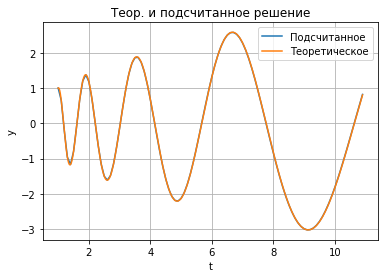

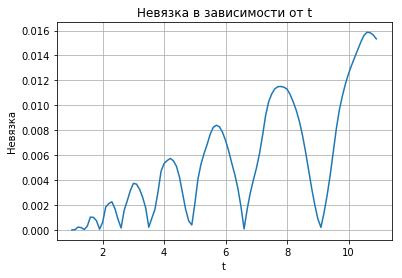

  Вычисленное x(101) = 0.8196515519871879
  Теоретическое x(101) = 1.0980225418856266
----------------------------------------------------------
----------------------------------------------------------
                   T = 101


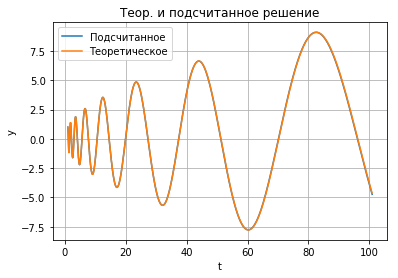

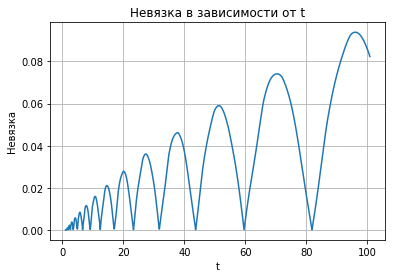

  Вычисленное x(101) = -4.730878086598228
  Теоретическое x(101) = -4.73890168470781
----------------------------------------------------------
----------------------------------------------------------
                   T = 1001


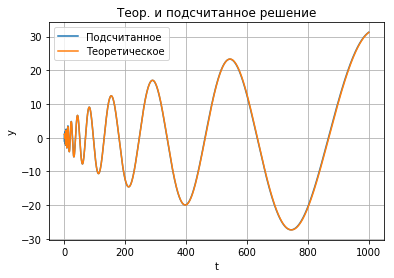

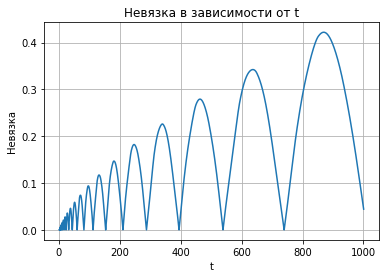

  Вычисленное x(101) = 31.29117892575612
  Теоретическое x(101) = 31.25354025178528
----------------------------------------------------------


In [9]:
for t_stop in T_list:
    describe_after_execution(t_theor)(dorman_prince)(system_of_eq, x_start.copy(), t_stop, h)

In [10]:
for t_stop in T_list:
    dorman_prince(system_of_eq, x_start, t_stop)

Метод Дормана-Принса дает очень хорошие результаты интегрирования. Его точность составляет $o(h^4)$.

## Метод трапеций

In [11]:
# TODO: придумай, что делать с методом трапеций
def trapezium(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Нам придется "подгядеть" f_(i+1), а затем взять полусумму с f_i
        x_tmp = x + h*funcs(0, x)
        # Результат прибавлять в качестве вектора касательной
        x += h*x_tmp
        y.append(x.copy())
    return y

In [12]:
x_5 = trapezium(system_of_eq, x_start, t_stop, h)

# Задание 2. Нелинейная система уравнений

Уравнение Ван-дер-Поля
$$
y'' + a (y^2 - 1) y' + y = 0 \\
y(0) = y_0 > 0; ~ y'(0) = 0, ~ 0 \leq t \leq 30, ~ a > 0 ~ (100 \div 1000)
$$

1) Проинтегрировать уравнение численно явными методами Рунге-Кутты с числом стадий 2, 3 и 4 с процедурой автоматического выбора шага.

Для этого представим уравнение в виде системы:
$$
\begin{cases}
    y' = -p \\
    p' = ap (y^2 - 1) + y
\end{cases}
$$

In [13]:
def runge_kutta(system, y_0_range, a_range, t_range, number_of_stages):
    from utils.runge_kutta import create_runge_solver
    from utils.plot_helpers import plot_lines
    from scipy.integrate import solve_ivp
    
    t0 = min(t_range)
    y_0_range = np.array(
        list(
            map(
                lambda v: np.array([t0, v, 0]), y_0_range
                )
            )
    )
    solver = create_runge_solver(number_of_stages)
    t_stop = max(t_range)
    
    for y_0 in y_0_range:
        y_0 = y_0.copy()
        print('y_0 is:')
        print(y_0)
        data = []
        for a in a_range:
            system_tmp = lambda y: system(a, t0, y)
            sol = solver(system_tmp, y_0, t_stop, h=0.1)
            data.append((sol[0], sol[1]))
        plot_lines(*data)

In [14]:
y_0_range = [0, 0.1, 5.1, 10.1, 20.1, 30.1, 50.1, 70.1, 100.1]

a_range = np.arange(100, 1000, 20)
t_min, t_max = 0, 30

system_of_eq = lambda a, t, y: np.array([
    1.0,
    -y[2], 
    a*y[2]*(y[1]**2 - 1) + y[1]
])

t_range = np.arange(t_min, t_max, 0.01)

Для числа стадий 4:

y_0 is:
[0. 0. 0.]


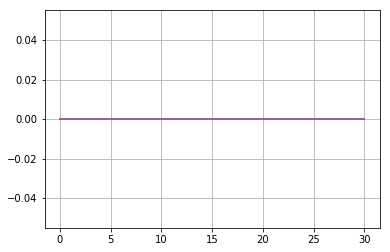

y_0 is:
[0.  0.1 0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/utils/runge_kutta.py:26: RuntimeWarning: invalid value encountered in multiply
  addition[1:] += h*K[j]*self.betas[i, j]


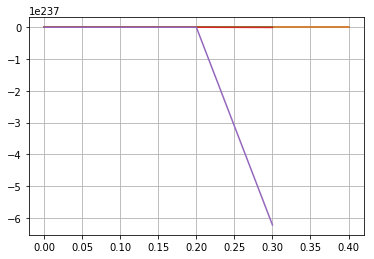

y_0 is:
[0.  5.1 0. ]


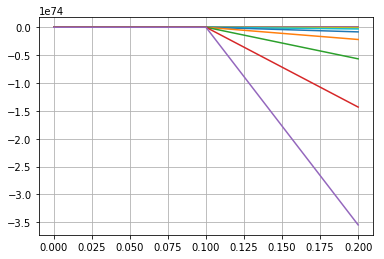

y_0 is:
[ 0.  10.1  0. ]


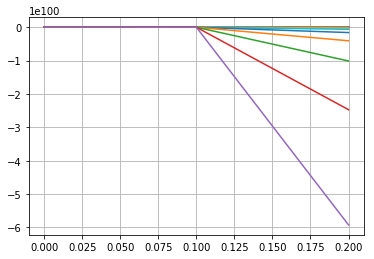

y_0 is:
[ 0.  20.1  0. ]


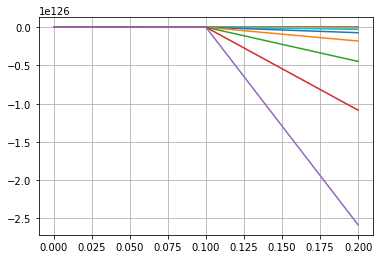

y_0 is:
[ 0.  30.1  0. ]


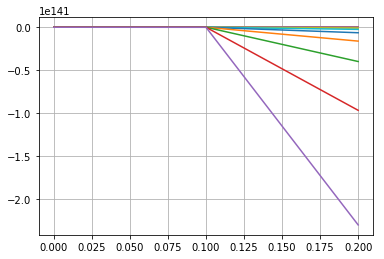

y_0 is:
[ 0.  50.1  0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


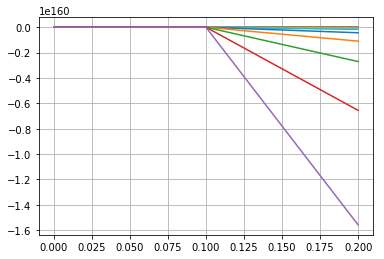

y_0 is:
[ 0.  70.1  0. ]


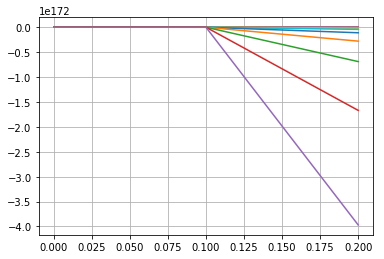

y_0 is:
[  0.  100.1   0. ]


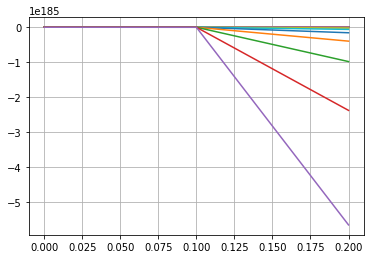

In [15]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=4)

Для числа стадий 3:

y_0 is:
[0. 0. 0.]


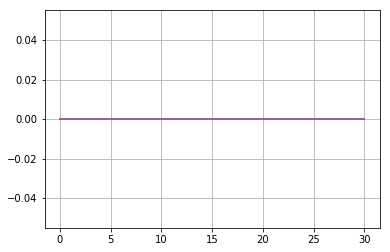

y_0 is:
[0.  0.1 0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


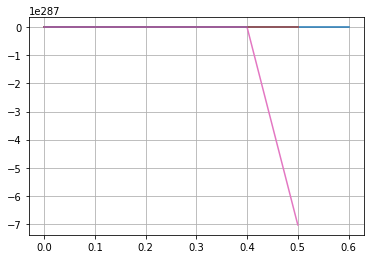

y_0 is:
[0.  5.1 0. ]


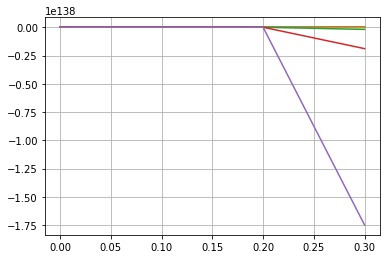

y_0 is:
[ 0.  10.1  0. ]


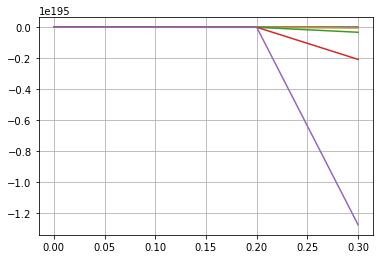

y_0 is:
[ 0.  20.1  0. ]


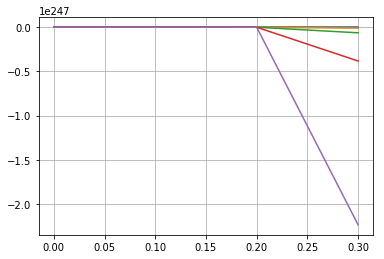

y_0 is:
[ 0.  30.1  0. ]


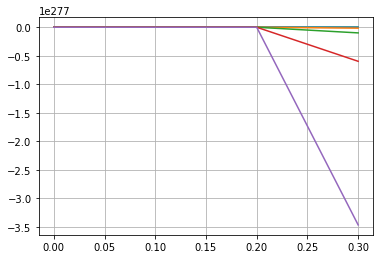

y_0 is:
[ 0.  50.1  0. ]


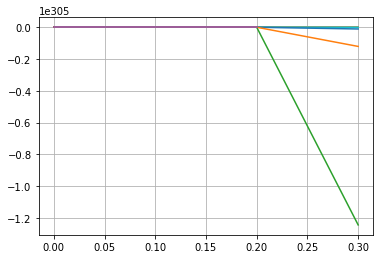

y_0 is:
[ 0.  70.1  0. ]


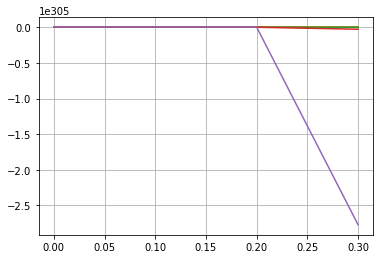

y_0 is:
[  0.  100.1   0. ]


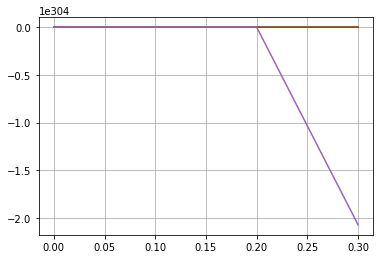

In [16]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=3)

Для числа стадий 2:

y_0 is:
[0. 0. 0.]


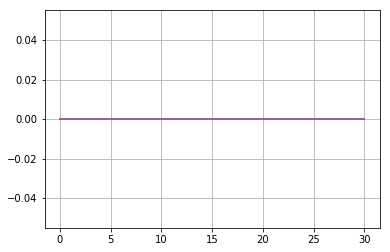

y_0 is:
[0.  0.1 0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/utils/runge_kutta.py:29: RuntimeWarning: invalid value encountered in multiply
  x += np.array([0] + list(h*K[i]*self.gammas[i]))
/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


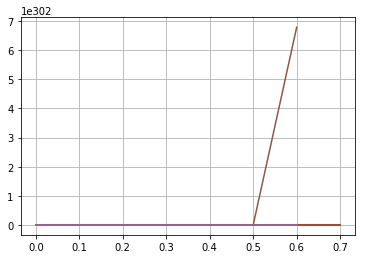

y_0 is:
[0.  5.1 0. ]


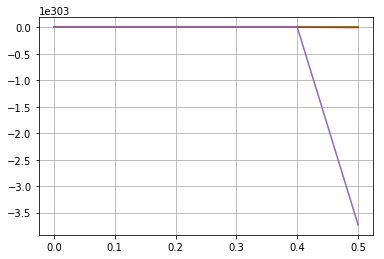

y_0 is:
[ 0.  10.1  0. ]


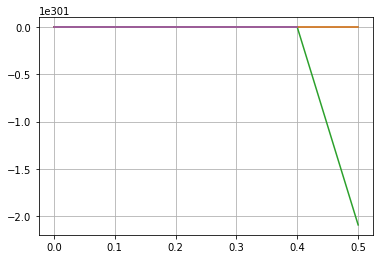

y_0 is:
[ 0.  20.1  0. ]


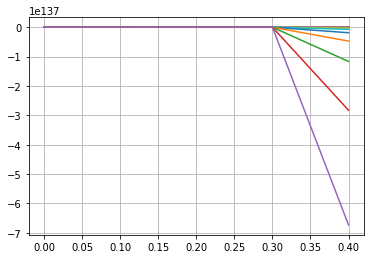

y_0 is:
[ 0.  30.1  0. ]


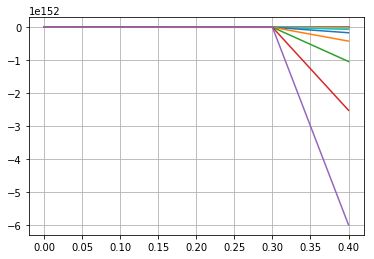

y_0 is:
[ 0.  50.1  0. ]


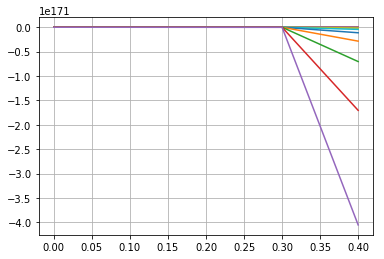

y_0 is:
[ 0.  70.1  0. ]


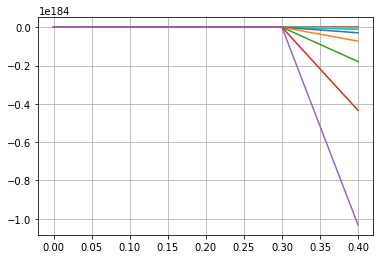

y_0 is:
[  0.  100.1   0. ]


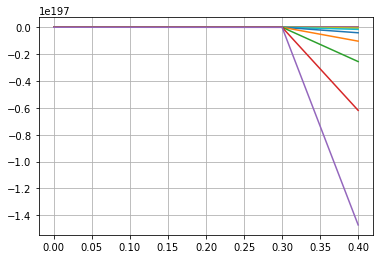

In [17]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=2)

При большом значении $y_0$ решение системы расходилось. Это объясняется тем, что при разных начальных параметрах мы приходим в разные особые точки.

При большом значении $a$ система плохо решалась. Похоже, эти значения $a$ отвечают той области, где решение не является устойчивым.

Тем не менее, система достаточно неплохо интегрируется для малых значений $a$ при небольшом значении $y_0$:

y_0 is:
[ 0.  -0.1  0. ]


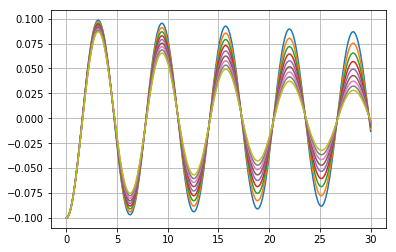

y_0 is:
[0.  0.1 0. ]


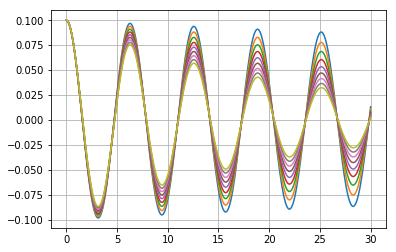

In [18]:
a_range = np.arange(0.01, 0.1, 0.01)
y_0_range = [-0.1, 0.1]

runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=4)

# Задание 3. Особые точки и особые траектории.

Система ОДУ,
описывающая динамику образования основных метаболитов в реакции свертывания крови:
$$
    \cfrac{\partial u_1}{t} = K_1 u_1 u_2 (1 - u_1) \cfrac{1 + K_2 u_1}{1 + K_3 u_3} - u_1 \\
    \cfrac{\partial u_2}{t} = u_1 - K_4 u_2 \\
    \cfrac{\partial u_3}{t} = K_5 u_1^2 - K_6 u_3
$$
Особые точки рассматриваемой системы определяются корнями следующего полинома:
$$
f (u_1) = u_1 \left(\dfrac{K_1 K_2}{K_4} u_1^3 + \left( \dfrac{K_1}{K_4} (1 - K_2) + \dfrac{K_3 K_5}{K_6} \right) u_1^2 - \dfrac{K_1}{K_4} u_1 + 1 \right)
$$
В системе всегда существует нулевая особая точка. Она устойчива при любых значениях параметров. Кроме того, у этого полинома всегда есть отрицательный корень. Количество положительных корней, определяющих особые точки системы, может меняться в зависимости от параметров модели от нуля до двух.

Табличные данные: $K_1 = 6.85; ~~ K_2 = 11.0; ~~ K_3 = 2.36; ~~ K_4 = 0.087; ~~ K_5 = 17.0$

In [19]:
K1, K2, K3, K4, K5 = 6.85, 11.0, 2.36, 0.087, 17.0
u_1, u_2, u_3, K_1, K_2, K_3, K_4, K_5, K_6 = symbols('u_1 u_2 u_3 K_1 K_2 K_3 K_4 K_5 K_6')

In [20]:
eq = K_1*K_2/K_4 * u_1**3 + (K_1/K_4*(1-K_2) + K_3*K_5/K_6)*u_1**2 - K_1/K_4*u_1 + 1

In [21]:
eq_s = eq.subs(K_1, K1)\
.subs(K_2, K2)\
.subs(K_3, K3)\
.subs(K_4, K4)\
.subs(K_5, K5)

In [22]:
from sympy import solve, re, im

k6_range = np.linspace(0, 0.2, 10000)[1:]
dots_real = np.array([[]])
dots_im = np.array([])
# Решение в общем виде
general_solutions = solve(eq_s, u_1)
for k6 in k6_range:
    # Подставляем разные значения k6
    solutions = [sol.subs(K_6, k6).evalf() for sol in general_solutions]
    dots_real = np.concatenate(
        (dots_real.reshape(-1, 3), np.array([re(i) for i in solutions]).reshape(1, -1))
        , axis=0)
    dots_im = np.concatenate(
        (dots_im.reshape(-1, 3), np.array([im(i) for i in solutions]).reshape(1, -1))
        , axis=0)

In [23]:
dots_real

array([[-2315.01062719265, 1.96348104850586e-5, 1.96348104850586e-5],
       [-1157.05082707749, 3.92852616073469e-5, 3.92852616073469e-5],
       [-771.064253271021, 5.89513701072519e-5, 5.89513701072519e-5],
       ...,
       [-0.124842503552276, 0.790573415586657, 0.0116985307334194],
       [-0.124839614373493, 0.790593727006098, 0.0116985009159842],
       [-0.124836725899509, 0.790614034489461, 0.0116984711048061]],
      dtype=object)

Начиная с некоторого момента координаты точек становятся комплексными числами, поэтому будет разумным отдельно изобразить их действительную и мнимую части

Первый корень:

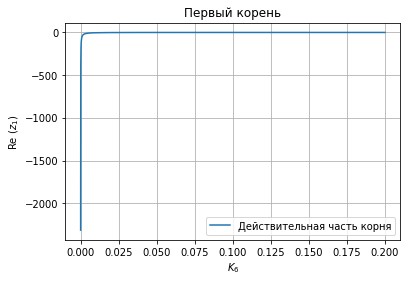

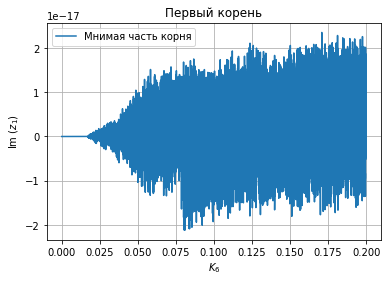

In [33]:
from utils.plot_helpers import plot_lines
plot_lines( (k6_range, dots_real[:,0], 'Действительная часть корня'), title='Первый корень', x_label=r'$K_6$', y_label=r'Re ($z_1$)')
plot_lines( (k6_range, dots_im[:,0], 'Мнимая часть корня'), title='Первый корень', x_label=r'$K_6$', y_label=r'Im ($z_1$)')

Второй корень:

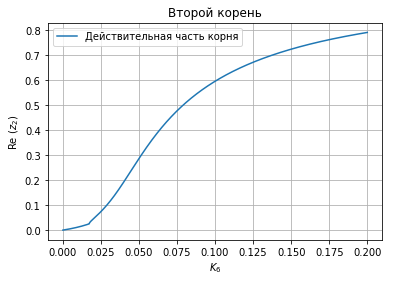

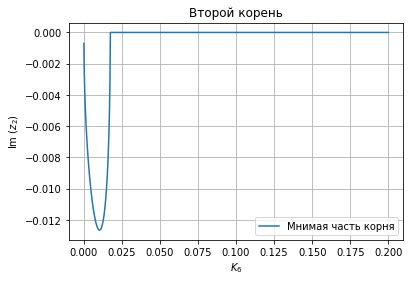

In [34]:
from utils.plot_helpers import plot_lines
plot_lines( (k6_range, dots_real[:,1], 'Действительная часть корня'), title='Второй корень', x_label=r'$K_6$', y_label=r'Re ($z_2$)')
plot_lines( (k6_range, dots_im[:,1], 'Мнимая часть корня'), title='Второй корень', x_label=r'$K_6$', y_label=r'Im ($z_2$)')

Третий корень:

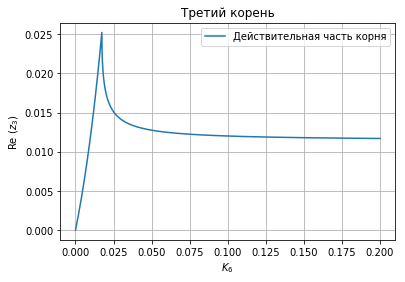

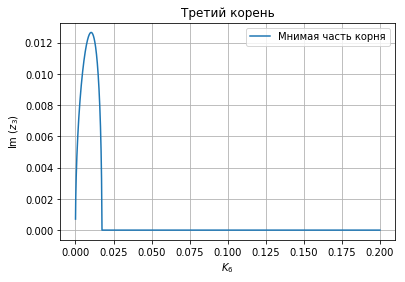

In [35]:
from utils.plot_helpers import plot_lines
plot_lines( (k6_range, dots_real[:,2], 'Действительная часть корня'), title='Третий корень', x_label=r'$K_6$', y_label=r'Re ($z_3$)')
plot_lines( (k6_range, dots_im[:,2], 'Мнимая часть корня'), title='Третий корень', x_label=r'$K_6$', y_label=r'Im ($z_3$)')

Видно, что 
мнимая часть первого корня сначала равна нулю, а потом начинает расти. Это соответствует $K_6 = 0.0173$ согласно описанию задания.
Для остальных корней на $K_6 = 0.0173$ приходится точка смены монотонности как действительной, так и мнимой частей.

Для промежутка $0 < K_6 < 0.193$ особые точки представляют из себя седло и узел, при $K_6 > 0.193$ - седло и фокус.

### Вблизи бифуркации Хопфа

При значении $K_6 = 0.0692$ вблизи бифуркации Хопфа происходит бифуракция рождения устойчивого предельного цикла и петли сепаратриссы седло-узла. Попробуем получить эту петлю численно.

In [36]:
# Запишем систему уравнений
diff_eqs = [
    K_1 * u_1 * u_2 * (1-u_1) * (1+K_2*u_1)/(1+K_3*u_3) - u_1,
    u_1 - K_4*u_2,
    K_5*u_1**2 - K_6*u_3
]

# Особая точка
hopf_K6 = 0.0692
# Подставим в систему все K
diff_eqs = [eq.subs(K_1, K1).subs(K_2, K2).subs(K_3, K3)
            .subs(K_4, K4).subs(K_5, K5).subs(K_6, hopf_K6) for eq in diff_eqs]

In [28]:
# Решим уравнение
special_dots = np.array(solve(eq_s.subs(K_6, hopf_K6)))

In [29]:
print(special_dots)

[-0.212867326053753 + 0.e-23*I 0.0123210596395346 - 0.e-23*I
 0.440229287076944 - 0.e-22*I]


In [30]:
lamb1, lamb2, lamb3 = lambdify((u_1, u_2, u_3), diff_eqs[0]), lambdify((u_1, u_2, u_3), diff_eqs[1]), lambdify((u_1, u_2, u_3), diff_eqs[2])
diff_eqs_scipy = lambda t, y: [
    lamb1(*y),
    lamb2(*y),
    lamb3(*y)
]

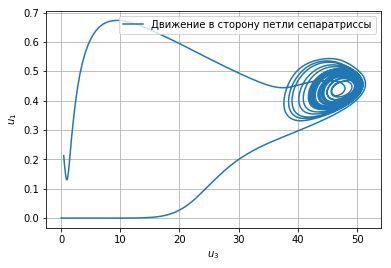

In [32]:
from scipy.integrate import solve_ivp

# На отрезке [100, 10000]
t_min, t_max = (100, 10000)
t_range = np.linspace(t_min, t_max, t_max*10)
y_0 = np.array([np.abs(re(i)) for i in special_dots], dtype=np.float)
# Мы решаем систему ДУ
solutions = solve_ivp(diff_eqs_scipy, (t_min, t_max), y_0, t_eval=t_range).y.T

# Строим далее фазовый портрет системы, откладывая u_1 в зависимости от u_3
plot_lines((solutions[:, 2], solutions[:, 0], r'Движение в сторону петли сепаратриссы'), x_label=r'$u_3$', y_label=r'$u_1$')